In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

comp_name = "sst"

if comp_name=="small":
    runs = ["f_default","g_halfsed","g_2xsed","g_halfdep", "g_2xdep"]
    run_names = ["Default","1/2x sed","2x sed","1/2x dep", "2x dep"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="all":
    runs = ["f_default","h_halfsed_all","h_2xsed_all","h_halfdep_all", "h_2xdep_all"]
    run_names = ["Default","1/2x sed (all)","2x sed (all)","1/2x dep (all)", "2x dep (all)"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="sed":
    runs = ["f_default","g_halfsed","g_2xsed","h_halfsed_all", "h_2xsed_all"]
    run_names = ["Default","1/2x sed (small)","2x sed (small)","1/2x sed (all)", "2x sed (all)"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen"]
elif comp_name=="dep":
    runs = ["f_default","g_halfdep","g_2xdep","h_halfdep_all", "h_2xdep_all", "i_lsascent_a"]
    run_names = ["Default","1/2x dep (small)","2x dep (small)","1/2x dep (all)", "2x dep (all)", "LS ascent"]
    colors = ["darkred","lightskyblue","mediumblue","lightgreen","darkgreen", "darkviolet"]
elif comp_name=="other":
    runs = ["f_default","f_def_pertlim","i_bgicenuc", "i_lsascent_a"]
    run_names = ["Default","Default (pertlim=0.1)","New ice nuc", "LS ascent"]
    colors = ["darkred","red","lightcoral", "darkviolet"]
elif comp_name=="sst":
    runs = ["f_default","j_304K","j_296K"]
    run_names = ["Default (300K)","Warm SST (304K)","Cool SST (296K)"]
    colors = ["grey","maroon","lightblue"]
markers = ["o","o","s","s","D","D","x"]
color_hi = 1
color_hi1 = 2

nt = 30*8+1 # days * 4
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"


In [2]:
def calc_rice(qi, ni):
    rho = 920 # kg/m3
    qi = qi # kg/kg
    ni =  ni # 1/kg
    r_ice = np.where((ni>1e-5),(3*qi/(4*np.pi*rho*ni))**(1/3),0)*1e6 # um
    return r_ice

def calc_ni(numice, qv, p, t):
    ni = numice * calc_rho(qv,p,t)  # 1/kg * kg/m3 = 1/m3
    return ni

def calc_rho(qv, p, t):
    """calculates density of air in kg/m3 for given input"""
    R =  287 # (Gas constant of air) J/(kg*K)
    Tv = (1 + 0.61*qv) * t # K
    rho = p / (R*Tv) # kg/m3
    return rho

def calc_rhice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] \
                  + 3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i  = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

In [3]:
# file="h0_varnames_3Dlev"
# varnames = open(file,"r").read().split("\n")  
# varnames

In [4]:
# fig = plt.figure(figsize=(5,12))
# for v in range(105):
#     plt.axhline(z[23+v],0,1, color="k")
# plt.ylim([0,20])
# plt.axis("off")
# plt.savefig("plots/vertical_spacing.png",dpi=120, transparent=True)
# plt.show()
# print(z[23:])
# print(z[28:65])

In [5]:
# a,b = 4,6
# runs = [runs[0]]+(runs[a:b])
# run_names = [run_names[0]]+run_names[a:b]
# colors = [colors[0]]+colors[a:b]
# runs

0 Default (300K)... in cloud only...IWC...NI...RICE...1 of 3 done.
1 Warm SST (304K)... in cloud only...IWC...NI...RICE...2 of 3 done.
2 Cool SST (296K)... in cloud only...IWC...NI...RICE...3 of 3 done.
saving to plots/compare_runs_IWC_NI_RICE_sstincld_.png


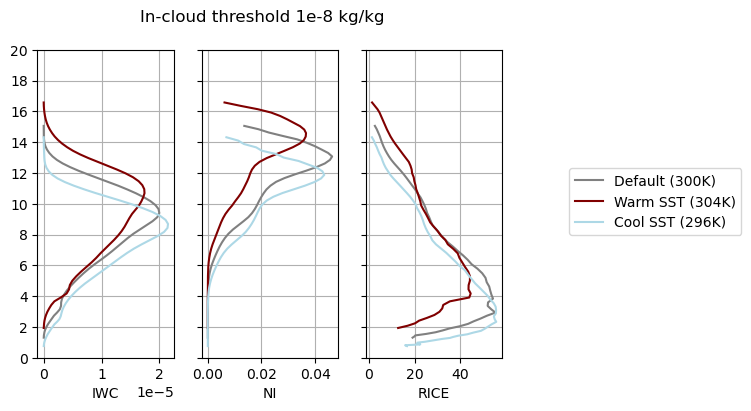

In [3]:
var_list = ["IWC","NI","RICE"]
logscale=False
plot_incld = True
fig, ax = plt.subplots(1,len(var_list), figsize=(2*len(var_list),4), sharey=True)
savename="IWC_NI_RICE_{}".format(comp_name)
if logscale:
    xmin, xmax = 1e-8,1e-4
    ax.set_xscale("log")
    savename += "log_"
else:
    xmin, xmax = 0,0
if plot_incld:
    savename+="incld_"

for i in range(len(runs)):
    print(i, run_names[i], end="...")
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    z = ds.Z3.mean(dim=["time","ncol"])
    ndays = nt//8
    ntime = len(ds.time.isel(time=slice(-nt,-1)))
    ds = ds.isel(time=slice(-nt,-1))
    if "NI" in var_list:
        ni = (calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds['T'])/1e6).assign_attrs({'long_name':'icnc', 'units':'cm-3'})
        ds = ds.assign({"NI":ni})
    if "RICE" in var_list:
        rice = calc_rice(ds.CLDICE, ds.NUMICE)
        rice = xr.DataArray(rice, dims=ni.dims, coords=ni.coords,
                            attrs={'long_name':'mass ice radius', 'units':'micron'})
        ds = ds.assign({"RICE":rice})
    ds = ds[var_list+["CLDICE"]].mean(dim=["time","ncol"])
    if plot_incld:
        ds = ds.where(ds.CLDICE>1e-8)
        fig.suptitle("In-cloud threshold 1e-8 kg/kg")
        print(" in cloud only...", end="")
    # print(ds.variables.values, end="...")
    c = colors[i]
    a = 1
    for j,v in enumerate(var_list):
        print(v, end="...")
        ax[j].plot(ds[v], z/1000, color=c, alpha=a,
            label=run_names[i])
        ax[j].set(xlabel=v, yticks=np.arange(0,21,2), ylim=[0,20])
        ax[j].grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename)
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()


save as plots/compare_runs_water_sed-sed.png


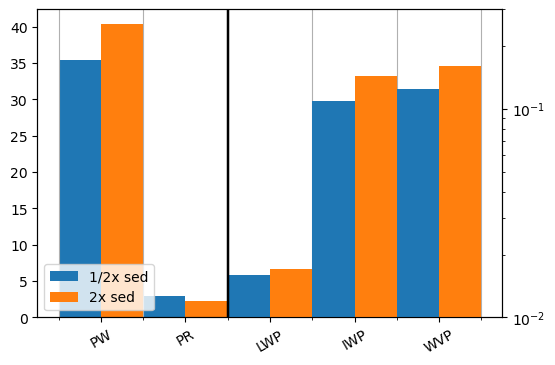

In [23]:
# 2D comparisons (like in comp_rcemip)
#### user input ####
plot_type="water" #options: "rad" for radiation, "water" for hydrometeors
plot=True
runs2 = ["g_halfsed","g_2xsed"]
run_names2 = ["1/2x sed", "2x sed"]
#### end user input ####
if plot:
    var_list_rad = ["RSFC", "RSFCC","RTOA","RTOAC","RNET","RNETC","OLR","ASR","QOCN","LHF","SHF"]
    var_list_water = ["PW","PR","LWP","IWP","WVP"]
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    savename=plot_type+"_"
    for i in range(len(runs2)):
        ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(runs[i],runs[i]))
        ds = ds.isel(time=slice(-nt, -1))
        var_dict = {}
        savename = savename + runs2[i][-3:] + "-"
        if plot_type=="rad":
            # rsfc, the net radiative flux at the sfc (SW-LW)
            var_dict["RSFC"] = (ds["FSNS"]-ds["FLNS"]).mean()
            var_dict["RSFCC"] = (ds["FSNSC"]-ds["FLNSC"]).mean()
            # rtoa, the net radiative flux at toa (SW-LW)
            var_dict["RTOA"] = (ds["FSNTOA"]-ds["FLUT"]).mean()
            var_dict["RTOAC"] = (ds["FSNTOAC"]-ds["FLUTC"]).mean()
            # rnet = rtoa − rsfc, where negative values indicate net atmospheric radiative cooling
            var_dict["RNET"] = ((ds["FSNTOA"]-ds["FLUT"]) - (ds["FSNS"]-ds["FLNS"])).mean()
            var_dict["RNETC"] = ((ds["FSNTOAC"]-ds["FLUTC"]) - (ds["FSNSC"]-ds["FLNSC"])).mean()
            # olr
            var_dict["OLR"] = ds["FLUT"].mean()
            # asr, absorbed sw radiation (i.e., net SW flux at TOA (total incoming - total outgoing))
            var_dict["ASR"] = ds["FSNTOA"].mean()
            # energy input into ocean
            var_dict["QOCN"] = ((ds["FSNS"]-ds["FLNS"])-ds["LHFLX"]-ds["SHFLX"]).mean()
            # lhf, latent heat flux
            var_dict["LHF"] = ds["LHFLX"].mean()
            # shf, sensible heat flux
            var_dict["SHF"] = ds["SHFLX"].mean()
            units_dict = zip(var_list_rad,["W/m2"]*len(var_list_rad))
        else: #plot_type=="water"
            # pw, precipitable water
            var_dict["PW"] = ds["TMQ"].mean()
            # precip, precipitation rate
            var_dict["PR"] = ((ds.PRECL)*1000*3600*24).mean() #m/s --> mm/day ==> m/s * 1000 mm/m * 3600s/1hr * 24hr/day = mm/day
            # LWP, liquid water path
            var_dict["LWP"] = ds["TGCLDLWP"].mean()
            # IWP, ice water path
            var_dict["IWP"] = ds["TGCLDIWP"].mean()
            # clwvi_avg, water vapor path
            var_dict["WVP"] = ds["TGCLDCWP"].mean()
            units_dict = zip(var_list_water,["kg/m2","mm/day","kg/m2","kg/m2","kg/m2"])
        # plot
        if plot_type=="rad":
            var_list=var_list_rad
        else:
            var_list=var_list_water
            if i==0:
                axt = ax.twinx()
        for j in range(len(var_list)):
            ci = "C0" if i==0 else "C1"
            if j==0:
                ax.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5, label=run_names2[i])
            else:
                if (plot_type=="water") & (j>1):
                    axt.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5)
                    axt.set_yscale("log")
                    axt.axvline(1.75, color='k')
                    axt.set_ylim([1e-2,3e-1])
                else:
                    ax.bar(j+(i/len(runs2)),var_dict[var_list[j]], color=ci, width=0.5)
    ax.set_xticks(np.arange(0.25,len(var_list),1), var_list)
    ax.set_xticks(np.arange(-0.25,len(var_list),1), minor=True)
    ax.tick_params(axis='x', labelrotation=30)
    ax.legend(loc=3)
    ax.grid(axis='x', which='minor')
    print("save as plots/compare_runs_{}.png".format(savename[:-1]))
    plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]))
    plt.show()

In [7]:
var_list

['IWC', 'NI', 'RICE']

saving to plots/compare_runs_QICLDFRAC_incldIWC_IWC_1e-08_small.png


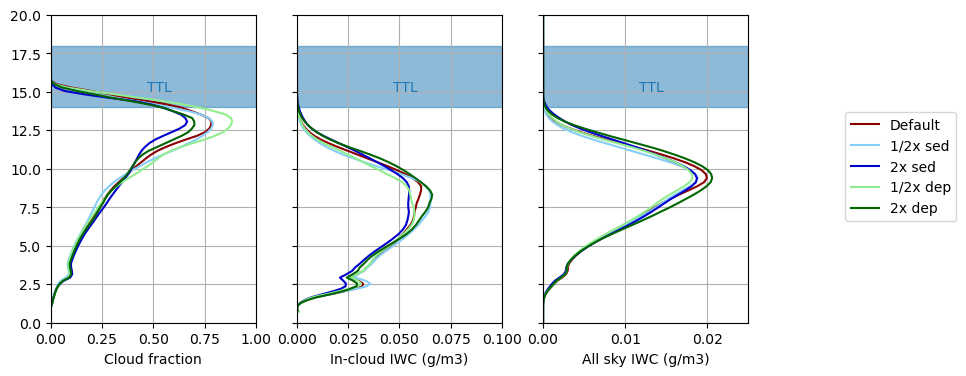

In [10]:
## plot in-cloud mean IWC and cloud fraction for given runs
## zoom into the TTL 
# runs = ["ck","ch"]

fig, ax = plt.subplots(1,3, figsize=(9,4))
xmaxs = [1,0.1,0.025]
qsmall=1e-8 #kg/kg
savename="QICLDFRAC_incldIWC_IWC_{}_{}".format(str(qsmall),comp_name)
for i in range(len(runs)):
    ### get cloud fraction and in-cloud mean IWC
    
    file = run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i])
    ds = xr.open_dataset(file).isel(time=slice(-nt,-1))
    z = ds.Z3.mean(dim=["time","ncol"])/1000
    if savename[:3]=="CLD":
        ### defined by qsmall IWC 
        ds = ds.IWC
        cld_frac = np.mean(np.where(ds>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.where(ds>qsmall).mean(dim=["time","ncol"])
        del ds
    elif savename[:3]=="QIC":
        ### defined by qsmall QI 
        cld_frac = np.mean(np.where(ds.CLDICE>qsmall,1,0), axis=(0,2))
        incld_iwc = ds.IWC.where(ds.CLDICE>qsmall).mean(dim=["time","ncol"])
        iwc = ds.IWC.mean(dim=["time","ncol"])
        del ds
    else:
        ### defined by model output of cloud fraction CLOUD
        cld_frac = ds.CLOUD.mean(dim=["time","ncol"])
        incld_iwc = ds.IWC.where(ds.CLOUD==1).mean(dim=["time","ncol"])
        del ds
    # if i==color_hi or i==0 or i==color_hi1:
    c = colors[i]
    a = 1
    # else:
    #     c = "gray"
    #     a = 0.3
    #     savename = savename + runs[i].lower()+"-"
    ### plot cld fraction, in-cld iwc, ttl in cld iwc
    ax[0].plot(cld_frac, z, color=c, alpha=a, label=run_names[i])
    ax[1].plot(incld_iwc*1000, z, color=c, alpha=a)
    # ax[2].plot(incld_iwc*1000, z, color=c, alpha=a)
    ax[2].plot(iwc*1000, z, color=c, alpha=a)
    xmaxs = np.max(np.array([xmaxs,[cld_frac.max(), incld_iwc.max(),incld_iwc[28:65].max()]]), axis=0)
    
ax[0].set_xlabel("Cloud fraction")
ax[1].set_xlabel("In-cloud IWC (g/m3)")
ax[2].set_xlabel("All sky IWC (g/m3)")
# ax[2].set_xlabel("In-cloud TTL IWC (g/m3)")

for j in range(3):
    ax[j].grid(True)
    ax[j].fill_between([0, 1], 14, 18, color="C0", alpha=0.5)
    if j==-1:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.5), xycoords="axes fraction")
        ax[j].set_ylim([12,20])
    else:
        ax[j].annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
        ax[j].set_ylim([0,20])
    ax[j].set_xlim([0,xmaxs[j]])
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
# ax[2].tick_params(labelrotation=20)
fig.legend(loc=6, bbox_to_anchor=(1.0, 0.5))
print("saving to plots/compare_runs_{}.png".format(savename))
plt.savefig("plots/compare_runs_{}.png".format(savename), dpi=120, bbox_inches="tight",pad_inches=1)
plt.show()

0 Default f_default...

KeyboardInterrupt: 

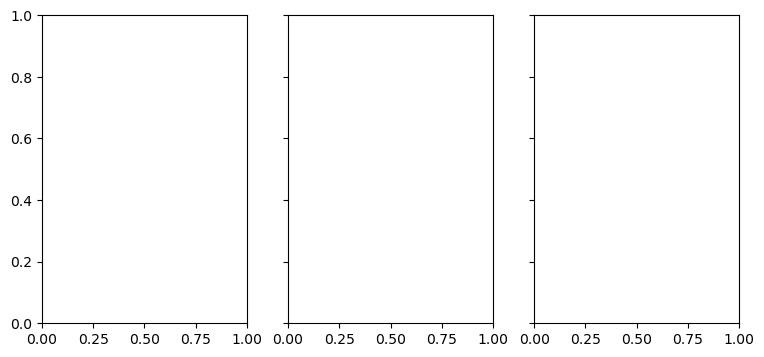

In [35]:
# Cloud radiative heating rates
# converted from K/s to K/day
var_list = ["QRL","QRS","Total heating rate (K/day)"]
fig, ax = plt.subplots(1,len(var_list), figsize=(3*len(var_list),4), sharey=True)
savename="heating-rates-Kday-1_"+comp_name
xmin, xmax = 0,0

for i in range(len(runs)):
    print(i, run_names[i], runs[i], end="...")
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    z = ds.Z3.mean(dim=["time","ncol"])
    ndays = nt//4
    ntime = len(ds.time.isel(time=slice(-nt+8,-1)))
    ds = ds.isel(time=slice(-nt+8,-1)) # K/s to K/day
    c = colors[i]
    a = 1
    qrl = ds["QRL"].mean(dim=["time","ncol"])*3600*24
    qrs = ds["QRS"].mean(dim=["time","ncol"])*3600*24
    qrt = qrl + qrs
    heating_rates = [qrl, qrs, qrt]
    for j,v in enumerate(heating_rates):
        print(var_list[j], end="...")
        ax[j].plot(v, z/1000, color=c, alpha=a,
            label=run_names[i])
        ax[j].set(xlabel=var_list[j], yticks=np.arange(0,21,2), ylim=[10,18], xlim=[-1,1])
        ax[j].grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename[:-1])
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()


0 Default f_default...T...RHice...1 of 5 done.
1 1/2x sed g_halfsed...T...RHice...2 of 5 done.
2 2x sed g_2xsed...T...RHice...3 of 5 done.
3 1/2x dep g_halfdep...T...RHice...4 of 5 done.
4 2x dep g_2xdep...T...RHice...5 of 5 done.
saving to plots/compare_runs_T_RHice_small.png


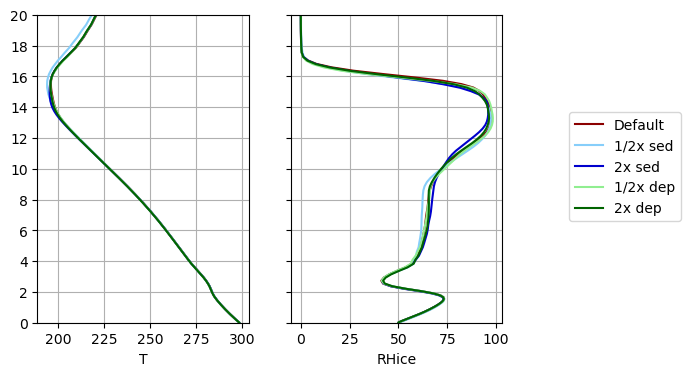

In [9]:
# RHice + Temperature mean profiles
var_list = ["T", "RHice"]
fig, ax = plt.subplots(1,len(var_list), figsize=(3*len(var_list),4), sharey=True)
savename="T_RHice_{}".format(comp_name)

for i in range(len(runs)):
    print(i, run_names[i], runs[i], end="...")
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    z = ds.Z3.mean(dim=["time","ncol"])
    ndays = nt//4
    ntime = len(ds.time.isel(time=slice(-nt+8,-1)))
    if runs[i]=="f_def_pertlim" or runs[i]=="f_default":
        t0 = ds["T"].isel(time=0).mean(dim="ncol")
    ds = ds.isel(time=slice(-ntime,-1)) # K/s to K/day
    c = colors[i]
    a = 1
    print(var_list[0], end="...")
    ax[0].plot(ds[var_list[0]].mean(axis=(0,2)), z/1000, color=c, alpha=a,
        label=run_names[i])
    ax[0].set(xlabel=var_list[0], yticks=np.arange(0,21,2), ylim=[0,20])
    if runs[i]=="f_def_pertlim":
        ax[0].plot(t0, z/1000, color=c, alpha=a-0.2, linestyle="dashed",
                   label=run_names[i]+" t=0")
    if runs[i]=="f_default":
        if "f_def_pertlim" in runs:
            ax[0].plot(t0, z/1000, color=c, alpha=a-0.2, linestyle="dashed",
                   label=run_names[i]+" t=0")
    ax[0].grid(True)
    print(var_list[1], end="...")
    rhice = calc_rhice(ds).mean(axis=(0,2))
    ax[1].plot(rhice, z/1000, color=c, alpha=a,
        label=run_names[i])
    ax[1].set(xlabel=var_list[1], yticks=np.arange(0,21,2), ylim=[0,20])
    ax[1].grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax[0].get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename)
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()


In [14]:
ds

<xarray.Dataset>
Dimensions:                   (ncol: 1296, lev: 128, ilev: 129, swband: 14,
                               lwband: 16, P3_input_dim: 16, P3_output_dim: 32,
                               time: 231, nbnd: 2)
Coordinates:
  * lev                       (lev) float64 2.58 3.23 3.88 ... 991.0 994.9 998.5
  * ilev                      (ilev) float64 2.255 2.905 3.555 ... 997.0 1e+03
  * swband                    (swband) float64 2.925e+03 3.625e+03 ... 1.71e+03
  * lwband                    (lwband) float64 130.0 375.0 ... 2.965e+03
  * P3_input_dim              (P3_input_dim) int32 1 2 3 4 5 ... 12 13 14 15 16
  * P3_output_dim             (P3_output_dim) int32 1 2 3 4 5 ... 28 29 30 31 32
  * time                      (time) object 2000-03-03 06:00:00 ... 2000-04-0...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/223)
    lat                       (ncol) float64 ...
    lon                       (ncol) float64 ...
    area                      (ncol) float64 ...
    hyam                      (lev) float64 ...
    hybm                      (lev) float64 ...
    P0                        float64 ...
    ...                        ...
    crm_grid_x                (time, ncol) float32 ...
    crm_grid_y                (time, ncol) float32 ...
    hstobie_linoz             (time, lev, ncol) float32 ...
    liq_ice_exchange          (time, lev, ncol) float32 ...
    vap_ice_exchange          (time, lev, ncol) float32 ...
    vap_liq_exchange          (time, lev, ncol) float32 ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         382e8c7a0e
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /glade/work/sturbeville/E3SM/inputdata/atm/cam/inic/ho...
    topography_file:   /glade/work/sturbeville/E3SM/inputdata/atm/cam/topo/US...
    time_period_freq:  hour_3

0 Default f_default...240 2000-03-02 03:00:00 2000-03-31 21:00:00...TMQ...1 of 5 done.
1 1/2x sed g_halfsed...240 2000-01-01 03:00:00 2000-01-30 21:00:00...TMQ...2 of 5 done.
2 2x sed g_2xsed...240 2000-02-15 03:00:00 2000-03-16 21:00:00...TMQ...3 of 5 done.
3 1/2x dep g_halfdep...240 2000-02-15 03:00:00 2000-03-16 21:00:00...TMQ...4 of 5 done.
4 2x dep g_2xdep...240 2000-02-15 03:00:00 2000-03-16 21:00:00...TMQ...5 of 5 done.
saving to plots/compare_runs_hist_TMQ_small.png


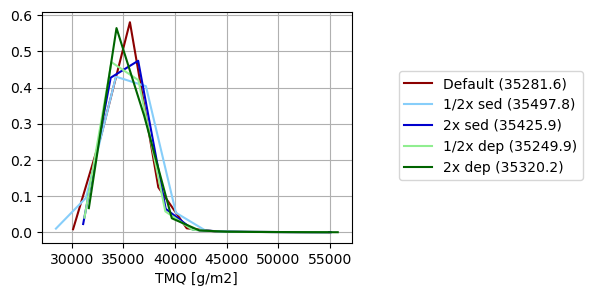

In [8]:
## histogram
var = "TMQ"
unit_fac = 1000 # 1000 for IWP/TMQ [g/m2]; 1000*3600*24 for PR [mm/day]; 
fig, ax = plt.subplots(1,1, figsize=(4,3))
savename="hist_"+var+"_"+comp_name
for i in range(len(runs)):
    print(i, run_names[i], runs[i], end="...")
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    # z = ds.Z3.mean(dim=["time","ncol"])
    ndays = nt
    ntime = len(ds.time.isel(time=slice(-nt,-1)))
    ds = ds.isel(time=slice(-ntime,-1)) # K/s to K/day
    print(ntime, ds.time[0].values,ds.time[-1].values, end="...")
    c = colors[i]
    a = 1
    print(var, end="...")
    mean_val = np.nanmean(ds[var])*unit_fac
    var_hist, bin_edges = np.histogram(ds[var]*unit_fac, 
                                       # bins=np.logspace(-4,4,40)
                                       bins=10
                                       # bins=np.linspace(0,2,25)
                                      )
    var_hist = var_hist/np.prod(ds[var].shape)
    bin_mids = (bin_edges[1:]+bin_edges[:-1])/2
    ax.plot(bin_mids, var_hist, color=c, alpha=a,
        label="{} ({:.1f})".format(run_names[i],mean_val))
    if var=="PRECL":
        units = "mm/day"
    elif var=="TGCLDIWP" or var=="TMQ":
        units = ds[var].units[1:]
    else:
        units = ds[var].units
    ax.set(xlabel="{} [{}]".format(var, units),
           # xscale="log"
          )
    ax.grid(True)
    print(i+1,"of",len(runs),"done.")

# ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc=6, bbox_to_anchor=(1.0, 0.5))
savename="plots/compare_runs_{}.png".format(savename)
print("saving to",savename)
plt.savefig(savename, dpi=200, bbox_inches="tight",pad_inches=1)
plt.show()